### Compare the generated data quality

In [3]:
# data_quality_comparison.py

"""
Data Quality Comparison Script

This script analyzes and compares the quality of academic paper datasets across three processing stages:

1. Raw Merged Data (merged_papers.jsonl) - Unprocessed raw data
2. Cleaned & Aligned Data (papers_final_aligned.jsonl) - After cleaning and field alignment
3. Enhanced & Filtered Data (papers_master_final.jsonl) - After data augmentation and filtering

Key functionalities:
- Computes comprehensive quality metrics for each dataset including completeness percentages, average lengths, and schema compliance
- Generates a terminal display of quality comparison table
- Exports comparison results to CSV format (data_quality_comparison_3stage.csv)

The analysis helps track data quality improvements through the processing pipeline.
"""

import json
import pandas as pd


# Utils
def load_jsonl(path):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line))
    return data

def safe_len(x):
    if isinstance(x, str):
        return len(x.strip())
    if isinstance(x, list):
        return len(x)
    return 0

# Statistics
def compute_stats(papers, stage_name):
    total = len(papers)

    stats = {
        "stage": stage_name,
        "num_papers": total,
        "has_abstract_%": 0,
        "has_authors_%": 0,
        "has_fields_%": 0,
        "has_keywords_%": 0,
        "avg_abstract_length": 0,
        "avg_title_length": 0,
        "schema_completeness_%": 0,
        "avg_overall_score": None,
    }

    if total == 0:
        return stats

    abstract_lens = []
    title_lens = []
    scores = []
    complete_schema = 0

    for p in papers:
        if safe_len(p.get("abstract")) > 0:
            stats["has_abstract_%"] += 1
            abstract_lens.append(len(p["abstract"]))

        if safe_len(p.get("authors")) > 0:
            stats["has_authors_%"] += 1

        if safe_len(p.get("fields_of_study")) > 0:
            stats["has_fields_%"] += 1

        if safe_len(p.get("keywords")) > 0:
            stats["has_keywords_%"] += 1

        if safe_len(p.get("title")) > 0:
            title_lens.append(len(p["title"]))

        # schema completeness
        required_fields = [
            "paper_id", "title", "abstract",
            "authors", "fields_of_study", "url"
        ]
        if all(p.get(f) for f in required_fields):
            complete_schema += 1

        # quality score (only exists after enhancement)
        qs = p.get("quality_scores")
        if isinstance(qs, dict) and "overall_score" in qs:
            scores.append(qs["overall_score"])

    # normalize
    for k in ["has_abstract_%", "has_authors_%", "has_fields_%", "has_keywords_%"]:
        stats[k] = round(stats[k] / total * 100, 2)

    stats["avg_abstract_length"] = round(
        sum(abstract_lens) / len(abstract_lens), 2
    ) if abstract_lens else 0

    stats["avg_title_length"] = round(
        sum(title_lens) / len(title_lens), 2
    ) if title_lens else 0

    stats["schema_completeness_%"] = round(
        complete_schema / total * 100, 2
    )

    if scores:
        stats["avg_overall_score"] = round(
            sum(scores) / len(scores), 2
        )

    return stats

# Main
if __name__ == "__main__":
    files = [
        ("merged_papers.jsonl", "Raw (Merged)"),
        ("papers_final_aligned.jsonl", "Cleaned & Aligned"),
        # ("papers_master_simple.jsonl", "Simple Enhanced"),
        ("papers_master_final.jsonl", "Enhanced & Filtered"),
    ]

    rows = []
    for path, name in files:
        papers = load_jsonl(path)
        rows.append(compute_stats(papers, name))

    df = pd.DataFrame(rows)

    print("\n====== DATA QUALITY COMPARISON (3 STAGES) ======\n")
    print(df.to_string(index=False))

    df.to_csv("data_quality_comparison_3stage.csv", index=False)
    print("\nSaved to data_quality_comparison_3stage.csv")



====== DATA QUALITY COMPARISON (3 STAGES) ======

              stage  num_papers  has_abstract_%  has_authors_%  has_fields_%  has_keywords_%  avg_abstract_length  avg_title_length  schema_completeness_%  avg_overall_score
       Raw (Merged)        7397           53.98          98.40         82.59             0.0              1220.41             68.47                  38.57                NaN
  Cleaned & Aligned        6242           53.11          98.59         79.86             0.0              1237.22             69.65                  35.12                NaN
Enhanced & Filtered        3236          100.00          99.78        100.00           100.0              1241.50             74.94                  99.78               6.81

Saved to data_quality_comparison_3stage.csv


### Visualize the result

In [ ]:
# visualize_dataset_quality.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("data_quality_comparison_3stage.csv")
stages = df["stage"].tolist()
x = np.arange(len(stages))

# Figure 1: Metadata Completeness
metrics = [
    "has_abstract_%",
    "has_authors_%",
    "has_fields_%",
    "has_keywords_%",
    "schema_completeness_%"
]

bar_width = 0.15

fig1, ax1 = plt.subplots(figsize=(9, 4))

for i, m in enumerate(metrics):
    ax1.bar(
        x + (i - len(metrics)/2) * bar_width + bar_width/2,
        df[m],
        bar_width,
        label=m.replace("_%", "").replace("_", " ").title()
    )

ax1.set_ylabel("Percentage (%)")
ax1.set_xticks(x)
ax1.set_xticklabels(stages)
ax1.set_title("Metadata Completeness Comparison")
ax1.legend(
    frameon=False,
    ncol=3,
    fontsize=9
)

plt.tight_layout()
plt.savefig("fig_metadata_completeness.png", dpi=300)
plt.close()

# Figure 2: Average Text Length
fig2, ax2 = plt.subplots(figsize=(6, 4))

bar_width = 0.35

ax2.bar(
    x - bar_width / 2,
    df["avg_abstract_length"],
    bar_width,
    label="Avg Abstract Length"
)

ax2.bar(
    x + bar_width / 2,
    df["avg_title_length"],
    bar_width,
    label="Avg Title Length"
)

ax2.set_ylabel("Average Length (characters)")
ax2.set_xticks(x)
ax2.set_xticklabels(stages)
ax2.set_title("Average Text Length Comparison")
ax2.legend(frameon=False)

plt.tight_layout()
plt.savefig("fig_text_length.png", dpi=300)
plt.close()

# Figure 3: Overall Quality Score
fig3, ax3 = plt.subplots(figsize=(6, 4))

ax3.bar(
    x,
    df["avg_overall_score"]
)

ax3.set_ylabel("Average Overall Quality Score")
ax3.set_xticks(x)
ax3.set_xticklabels(stages)
ax3.set_title("Overall Quality Score Comparison")


min_score = df["avg_overall_score"].min()
max_score = df["avg_overall_score"].max()
ax3.set_ylim(min_score - 0.5, max_score + 0.5)

plt.tight_layout()
plt.savefig("fig_quality_score.png", dpi=300)
plt.close()

print("Saved figures:")
print(" - fig_metadata_completeness.png")
print(" - fig_text_length.png")
print(" - fig_quality_score.png")


Saved figures:
 - fig_metadata_completeness.png
 - fig_text_length.png
 - fig_quality_score.png


Sample CSV file created: paper_quality_data.csv

Data loaded successfully:
                 Stage  Num_Papers Avg_Novelty_Score Avg_Technical_Depth Avg_Clarity_Score Avg_Impact_Potential Avg_Overall_Score  Confidence  Avg_Novelty_Score_value  Avg_Technical_Depth_value  Avg_Clarity_Score_value  Avg_Impact_Potential_value  Avg_Overall_Score_value
0         Raw (Merged)        7397           5.21/10             5.68/10           6.94/10              5.89/10           5.93/10       0.742                     5.21                       5.68                     6.94                        5.89                     5.93
1    Cleaned & Aligned        6242           5.47/10             5.91/10           7.56/10              6.32/10           6.28/10       0.801                     5.47                       5.91                     7.56                        6.32                     6.28
2  Enhanced & Filtered        3236           5.93/10             6.33/10           8.02/10              6.96/

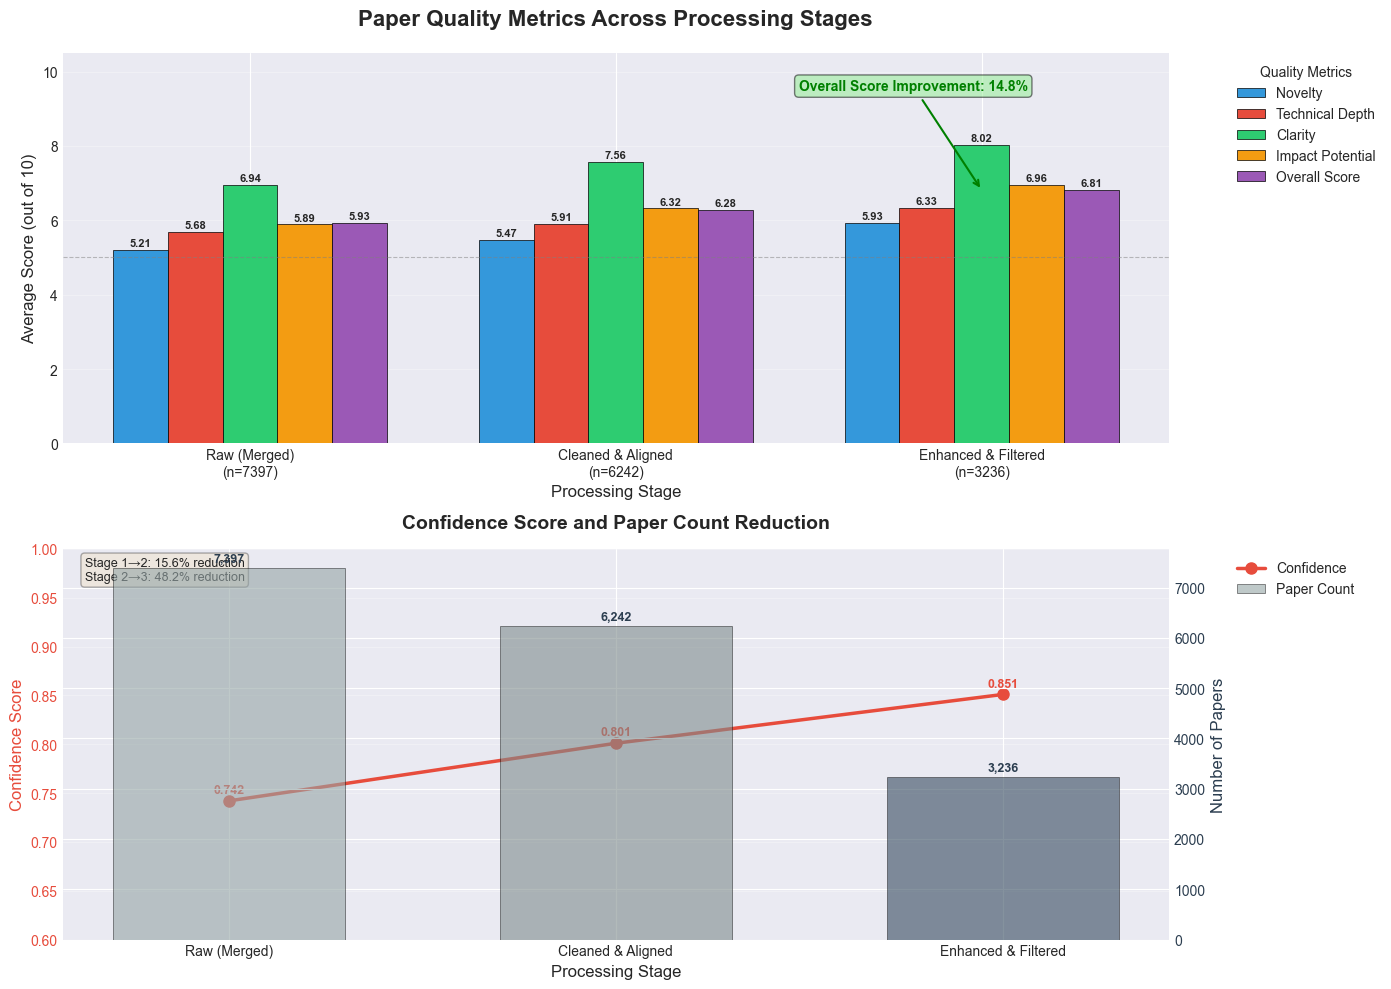

2. Creating radar chart...


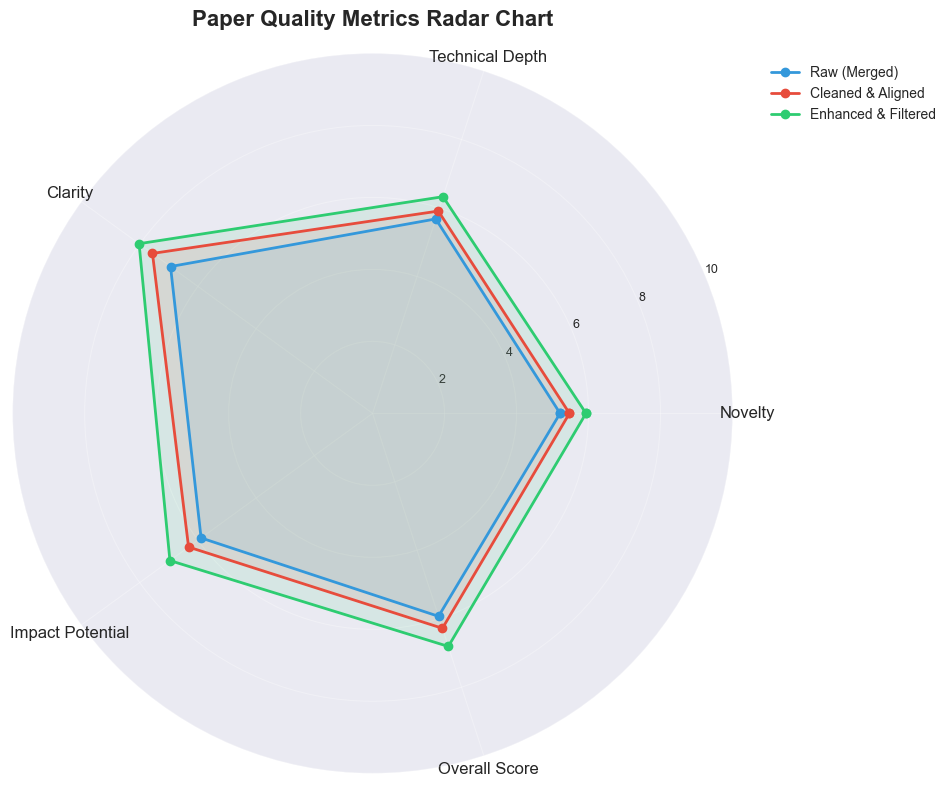

3. Creating improvement chart...


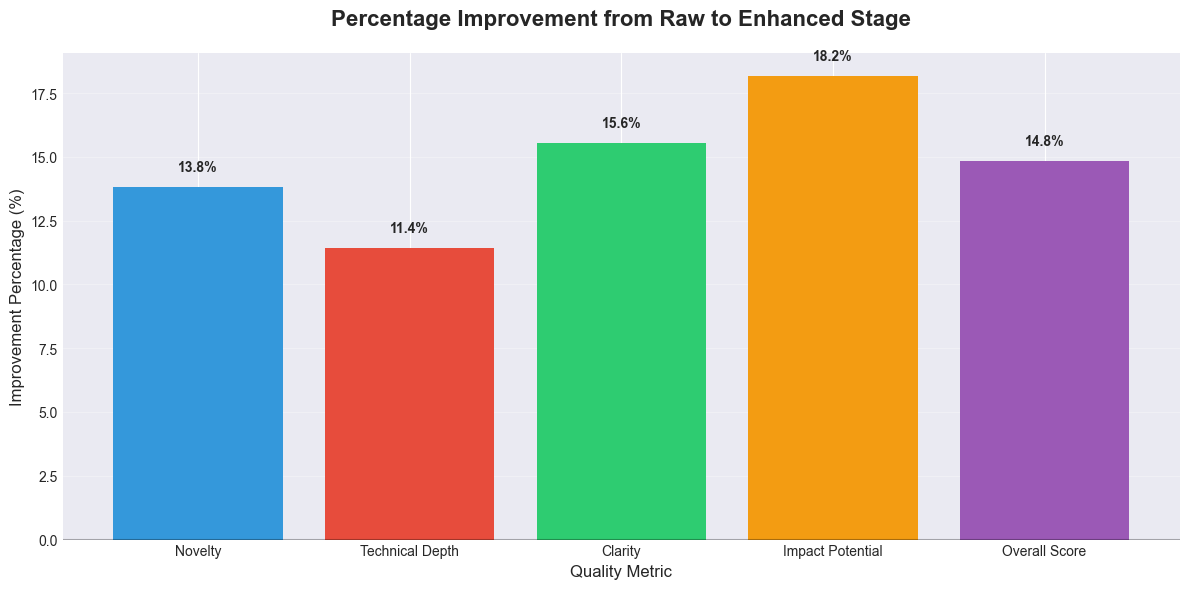


Visualizations saved as:
  - paper_quality_comparison.png
  - paper_quality_radar.png
  - quality_improvement.png

Summary Statistics:
--------------------------------------------------
Total papers processed: 16,875
Final papers retained: 3,236
Retention rate: 43.7%
Overall quality improvement: 14.8%
Confidence improvement: 14.7%


In [ ]:
# visualize_improvement.py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rcParams

# Set style for better visuals
plt.style.use('seaborn-v0_8-darkgrid')
rcParams.update({
    'figure.autolayout': True,
    'figure.figsize': (12, 7),
    'axes.titlesize': 16,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10
})

# Read data from CSV file
def load_and_process_data(csv_file):
    """Load and preprocess the data from CSV file"""
    df = pd.read_csv(csv_file)
    
    # Extract numeric values from score columns (e.g., convert "5.21/10" to 5.21)
    score_columns = ['Avg_Novelty_Score', 'Avg_Technical_Depth', 
                     'Avg_Clarity_Score', 'Avg_Impact_Potential', 'Avg_Overall_Score']
    
    for col in score_columns:
        df[f'{col}_value'] = df[col].apply(lambda x: float(str(x).split('/')[0]) if isinstance(x, str) and '/' in x else float(x))
    
    return df

def create_grouped_bar_chart(df, output_file='paper_quality_comparison.png'):
    """Create a grouped bar chart comparing metrics across stages"""
    
    # Define stages and metrics
    stages = df['Stage'].tolist()
    metrics = ['Novelty', 'Technical Depth', 'Clarity', 'Impact Potential', 'Overall Score']
    metric_columns = ['Avg_Novelty_Score_value', 'Avg_Technical_Depth_value', 
                     'Avg_Clarity_Score_value', 'Avg_Impact_Potential_value', 
                     'Avg_Overall_Score_value']
    
    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # 1. Main grouped bar chart for quality metrics
    x = np.arange(len(stages))
    width = 0.15
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    
    for i, (metric, col, color) in enumerate(zip(metrics, metric_columns, colors)):
        offset = (i - len(metrics)/2) * width + width/2
        values = df[col].values
        bars = ax1.bar(x + offset, values, width, label=metric, color=color, edgecolor='black', linewidth=0.5)
        
        # Add value labels on top of bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{value:.2f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    ax1.set_xlabel('Processing Stage')
    ax1.set_ylabel('Average Score (out of 10)')
    ax1.set_title('Paper Quality Metrics Across Processing Stages', fontsize=16, fontweight='bold', pad=20)
    ax1.set_xticks(x)
    ax1.set_xticklabels([f"{stage}\n(n={int(df.loc[df['Stage']==stage, 'Num_Papers'].values[0])})" 
                         for stage in stages], fontsize=10)
    ax1.set_ylim(0, 10.5)
    ax1.axhline(y=5, color='gray', linestyle='--', alpha=0.5, linewidth=0.8)
    ax1.legend(title='Quality Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add grid
    ax1.yaxis.grid(True, alpha=0.3)
    ax1.set_axisbelow(True)
    
    # 2. Confidence and paper count subplot
    fig.subplots_adjust(hspace=0.3)
    
    # Confidence line with markers
    confidence_values = df['Confidence'].values
    line1 = ax2.plot(x, confidence_values, marker='o', markersize=8, 
                     linewidth=2.5, color='#e74c3c', label='Confidence', zorder=3)
    ax2.set_xlabel('Processing Stage')
    ax2.set_ylabel('Confidence Score', color='#e74c3c')
    ax2.tick_params(axis='y', labelcolor='#e74c3c')
    ax2.set_ylim(0.6, 1.0)
    ax2.set_xticks(x)
    ax2.set_xticklabels(stages, fontsize=10)
    ax2.set_title('Confidence Score and Paper Count Reduction', fontsize=14, fontweight='bold', pad=15)
    
    # Add confidence value labels
    for i, (xi, yi) in enumerate(zip(x, confidence_values)):
        ax2.text(xi, yi + 0.005, f'{yi:.3f}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold', color='#e74c3c')
    
    # Paper count as bar chart on secondary y-axis
    ax2b = ax2.twinx()
    paper_counts = df['Num_Papers'].values
    colors_bar = ['#95a5a6', '#7f8c8d', '#34495e']
    bars = ax2b.bar(x, paper_counts, width=0.6, alpha=0.6, 
                    color=colors_bar, edgecolor='black', linewidth=0.5, label='Paper Count')
    ax2b.set_ylabel('Number of Papers', color='#2c3e50')
    ax2b.tick_params(axis='y', labelcolor='#2c3e50')
    
    # Add paper count labels
    for bar, count in zip(bars, paper_counts):
        height = bar.get_height()
        ax2b.text(bar.get_x() + bar.get_width()/2., height + 50,
                 f'{count:,}', ha='center', va='bottom', fontsize=9, 
                 fontweight='bold', color='#2c3e50')
    
    # Add legend for both lines
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1))
    
    # Add grid
    ax2.yaxis.grid(True, alpha=0.3)
    ax2.set_axisbelow(True)
    
    # Add percentage reduction text
    reduction_text = []
    for i in range(1, len(stages)):
        reduction = (1 - paper_counts[i]/paper_counts[i-1]) * 100
        reduction_text.append(f'{reduction:.1f}% reduction')
    
    if reduction_text:
        ax2.text(0.02, 0.98, f'Stage 1→2: {reduction_text[0]}\nStage 2→3: {reduction_text[1]}', 
                transform=ax2.transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Add overall improvement annotation
    overall_improvement = ((df.loc[df['Stage']=='Enhanced & Filtered', 'Avg_Overall_Score_value'].values[0] - 
                           df.loc[df['Stage']=='Raw (Merged)', 'Avg_Overall_Score_value'].values[0]) / 
                           df.loc[df['Stage']=='Raw (Merged)', 'Avg_Overall_Score_value'].values[0]) * 100
    
    ax1.annotate(f'Overall Score Improvement: {overall_improvement:.1f}%', 
                xy=(2, df.loc[df['Stage']=='Enhanced & Filtered', 'Avg_Overall_Score_value'].values[0]), 
                xytext=(1.5, 9.5),
                arrowprops=dict(arrowstyle='->', color='green', lw=1.5),
                fontsize=10, fontweight='bold', color='green',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def create_radar_chart(df, output_file='paper_quality_radar.png'):
    """Create a radar chart showing metrics for each stage"""
    
    # Extract data
    stages = df['Stage'].tolist()
    metrics = ['Novelty', 'Technical Depth', 'Clarity', 'Impact Potential', 'Overall Score']
    metric_columns = ['Avg_Novelty_Score_value', 'Avg_Technical_Depth_value', 
                     'Avg_Clarity_Score_value', 'Avg_Impact_Potential_value', 
                     'Avg_Overall_Score_value']
    
    # Prepare data for radar chart
    data = {}
    for i, stage in enumerate(stages):
        data[stage] = df.loc[df['Stage']==stage, metric_columns].values[0]
    
    # Number of variables
    N = len(metrics)
    
    # Create angles for radar chart
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the polygon
    
    # Create radar chart
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))
    
    # Colors for each stage
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    
    # Plot each stage
    for i, (stage, color) in enumerate(zip(stages, colors)):
        values = data[stage].tolist()
        values += values[:1]  # Close the polygon
        ax.plot(angles, values, 'o-', linewidth=2, label=stage, color=color)
        ax.fill(angles, values, alpha=0.1, color=color)
    
    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, fontsize=12)
    ax.set_ylim(0, 10)
    ax.set_yticks([2, 4, 6, 8, 10])
    ax.set_yticklabels(['2', '4', '6', '8', '10'], fontsize=9)
    ax.set_title('Paper Quality Metrics Radar Chart', fontsize=16, fontweight='bold', pad=20)
    
    # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def create_improvement_bar_chart(df, output_file='quality_improvement.png'):
    """Create a bar chart showing improvement percentages"""
    
    # Calculate percentage improvement from Raw to Enhanced stage
    metrics = ['Novelty', 'Technical Depth', 'Clarity', 'Impact Potential', 'Overall Score']
    metric_columns = ['Avg_Novelty_Score_value', 'Avg_Technical_Depth_value', 
                     'Avg_Clarity_Score_value', 'Avg_Impact_Potential_value', 
                     'Avg_Overall_Score_value']
    
    raw_values = df.loc[df['Stage']=='Raw (Merged)', metric_columns].values[0]
    enhanced_values = df.loc[df['Stage']=='Enhanced & Filtered', metric_columns].values[0]
    
    improvements = ((enhanced_values - raw_values) / raw_values) * 100
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bars = ax.bar(metrics, improvements, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6'])
    ax.set_xlabel('Quality Metric')
    ax.set_ylabel('Improvement Percentage (%)')
    ax.set_title('Percentage Improvement from Raw to Enhanced Stage', fontsize=16, fontweight='bold', pad=20)
    
    # Add value labels
    for bar, value in zip(bars, improvements):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Add horizontal line at 0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # Add grid
    ax.yaxis.grid(True, alpha=0.3)
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def main():
    """Main function to generate all visualizations"""
    
    # Create sample CSV data (replace with actual file reading)
    data = """Stage,Num_Papers,Avg_Novelty_Score,Avg_Technical_Depth,Avg_Clarity_Score,Avg_Impact_Potential,Avg_Overall_Score,Confidence
Raw (Merged),7397,5.21/10,5.68/10,6.94/10,5.89/10,5.93/10,0.742
Cleaned & Aligned,6242,5.47/10,5.91/10,7.56/10,6.32/10,6.28/10,0.801
Enhanced & Filtered,3236,5.93/10,6.33/10,8.02/10,6.96/10,6.81/10,0.851"""
    
    # Save sample data to CSV
    with open('paper_quality_data.csv', 'w') as f:
        f.write(data)
    
    print("Sample CSV file created: paper_quality_data.csv")
    
    # Load and process data
    try:
        df = load_and_process_data('paper_quality_data.csv')
        print("\nData loaded successfully:")
        print(df.to_string())
        
        # Create visualizations
        print("\nCreating visualizations...")
        
        # 1. Main grouped bar chart
        print("1. Creating grouped bar chart...")
        fig1 = create_grouped_bar_chart(df, 'paper_quality_comparison.png')
        
        # 2. Radar chart
        print("2. Creating radar chart...")
        fig2 = create_radar_chart(df, 'paper_quality_radar.png')
        
        # 3. Improvement chart
        print("3. Creating improvement chart...")
        fig3 = create_improvement_bar_chart(df, 'quality_improvement.png')
        
        print("\nVisualizations saved as:")
        print("  - paper_quality_comparison.png")
        print("  - paper_quality_radar.png")
        print("  - quality_improvement.png")
        
        # Print summary statistics
        print("\nSummary Statistics:")
        print("-" * 50)
        print(f"Total papers processed: {df['Num_Papers'].sum():,}")
        print(f"Final papers retained: {df.loc[df['Stage']=='Enhanced & Filtered', 'Num_Papers'].values[0]:,}")
        retention_rate = (df.loc[df['Stage']=='Enhanced & Filtered', 'Num_Papers'].values[0] / 
                        df.loc[df['Stage']=='Raw (Merged)', 'Num_Papers'].values[0]) * 100
        print(f"Retention rate: {retention_rate:.1f}%")
        print(f"Overall quality improvement: {((df.loc[df['Stage']=='Enhanced & Filtered', 'Avg_Overall_Score_value'].values[0] - df.loc[df['Stage']=='Raw (Merged)', 'Avg_Overall_Score_value'].values[0]) / df.loc[df['Stage']=='Raw (Merged)', 'Avg_Overall_Score_value'].values[0]) * 100:.1f}%")
        print(f"Confidence improvement: {((df.loc[df['Stage']=='Enhanced & Filtered', 'Confidence'].values[0] - df.loc[df['Stage']=='Raw (Merged)', 'Confidence'].values[0]) / df.loc[df['Stage']=='Raw (Merged)', 'Confidence'].values[0]) * 100:.1f}%")
        
    except FileNotFoundError:
        print("Error: CSV file not found. Please ensure 'paper_quality_data.csv' exists in the current directory.")
    except Exception as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()

#### Ruler Based Multi-dimensional Quality Scoring

In [ ]:
# quality_scoring.py
"""
================================================================================
Enhanced Quality Scoring Module for Academic Papers
================================================================================

Purpose:
This module provides advanced quality assessment for academic papers by implementing
a multi-dimensional scoring system that evaluates papers based on completeness,
recency, academic substance, methodological rigor, impact potential, and domain
relevance. It is designed to process cleaned papers and generate enhanced quality
scores with confidence metrics and detailed statistical analysis.

Key Features:
1. MULTI-DIMENSIONAL QUALITY ASSESSMENT:
   - Completeness Score (15%): Evaluates presence and quality of key metadata fields
   - Recency Score (20%): Assesses publication timeliness using exponential decay
   - Academic Substance Score (30%): Measures technical depth and innovation
   - Methodological Rigor Score (25%): Evaluates research methodology and reproducibility
   - Impact Potential Score (10%): Assesses practical applications and influence potential
   - Domain Relevance Score (15%): Measures alignment with target research topics

2. ADVANCED SCORING ALGORITHMS:
   - Exponential decay for recency scoring to prioritize recent publications
   - Technical term extraction for academic substance evaluation
   - Heuristic pattern matching for methodological rigor assessment
   - Penalty system for low-quality or suspicious content
   - Confidence scoring based on data completeness and reliability

3. COMPREHENSIVE STATISTICAL ANALYSIS:
   - Detailed quality score distribution across six tiers (Excellent to Low)
   - Correlation analysis between quality scores and text length/recency
   - Mean, median, standard deviation, min/max score calculations
   - Preservation of original quality scores for comparison

4. INTELLIGENT DOMAIN ADAPTATION:
   - Dynamic domain term matching for relevance scoring
   - Common AI/ML/CV/Robo/NLP terminology library for baseline comparison
   - Category-based relevance assessment for computer science papers

5. OUTPUT AND REPORTING:
   - Enhanced JSONL output with comprehensive quality metadata
   - Detailed quality statistics in JSON format
   - Console reporting of top-performing papers
   - Tier-based distribution analysis

Input Requirements:
- cleaned_papers.jsonl (output from original cleaning pipeline)
  This file should contain papers with cleaned text and basic metadata.

Output Files:
1. enhanced_scored_papers.jsonl - Papers with enhanced quality scores
2. quality_statistics.json - Comprehensive quality score statistics

Scoring Methodology:
Each paper receives a total score (0-1) based on weighted components:
- Total Score = Σ(Component_Score × Weight) - Penalty
- Quality Tiers: Excellent (≥0.8), High (0.7-0.8), Good (0.6-0.7), 
  Medium (0.5-0.6), Fair (0.4-0.5), Low (<0.4)

Penalty System:
Penalties are applied for:
- Short abstracts (<100 characters: 0.2, <50 characters: 0.4)
- Short titles (<10 characters: 0.1)
- Suspicious content patterns (e.g., draft indicators)
- Duplicate content (0.3 penalty)

Confidence Scoring:
Confidence (0-1) is calculated based on:
- Data completeness (normalized completeness score)
- Text length (longer texts = higher confidence)
- Technical term density (more terms = higher confidence)

Usage:
Run as standalone script: python quality_scoring.py
Or integrate into pipeline via main() function.

Note:
This module is designed to be run AFTER the cleaning pipeline and BEFORE
provenance_compliance.py in the data processing workflow.
================================================================================
"""

import json
import re
import numpy as np
from datetime import datetime
import statistics
from typing import Dict, List, Tuple

def load_jsonl_file(filepath: str) -> List[Dict]:
    """Load JSONL file"""
    papers = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            papers.append(json.loads(line.strip()))
    return papers

def enhanced_quality_scoring(paper: Dict, topic_terms: List[str] = None) -> Dict:
    """Enhanced quality scoring for academic papers"""
    if topic_terms is None:
        topic_terms = []
    
    scores = {}
    
    # 1. Basic quality scores
    scores['completeness'] = enhanced_score_completeness(paper) * 0.15
    scores['recency'] = enhanced_score_recency(paper) * 0.20
    
    # 2. Academic quality scores
    scores['academic_substance'] = score_academic_substance(paper) * 0.30
    scores['methodological_rigor'] = score_methodological_rigor(paper) * 0.25
    scores['impact_potential'] = score_impact_potential(paper) * 0.10
    
    # 3. Domain relevance score
    scores['domain_relevance'] = score_domain_relevance(paper, topic_terms) * 0.15
    
    # Calculate weighted total score
    total_score = sum(scores.values())
    
    # 4. Penalty calculation
    penalty = calculate_penalty(paper)
    total_score = max(0, total_score - penalty)
    
    # 5. Confidence calculation
    confidence = calculate_confidence(paper, scores)
    
    return {
        'scores': scores,
        'total_score': round(total_score, 3),
        'confidence': confidence,
        'quality_tier': calculate_quality_tier(total_score),
        'penalty_applied': penalty
    }

def enhanced_score_completeness(paper: Dict) -> float:
    """Enhanced completeness scoring"""
    score = 0.0
    mandatory_fields = ['title', 'abstract', 'authors']
    optional_fields = ['categories', 'comments', 'publish_date', 'url']
    
    # Check mandatory fields
    for field in mandatory_fields:
        if paper.get(field):
            if field == 'abstract' and len(paper['abstract']) > 100:
                score += 0.3
            elif field == 'title' and len(paper['title']) > 10:
                score += 0.25
            elif field == 'authors' and len(paper['authors']) > 0:
                score += 0.25
        else:
            # Penalty for missing mandatory fields
            return 0.0
    
    # Check optional fields
    for field in optional_fields:
        if paper.get(field):
            if field == 'categories' and len(paper['categories']) > 0:
                score += 0.05
            elif field == 'comments' and len(paper['comments']) > 0:
                score += 0.05
            elif field in ['publish_date', 'url']:
                score += 0.05
    
    return min(1.0, score)

def enhanced_score_recency(paper: Dict) -> float:
    """Enhanced recency scoring using exponential decay"""
    if 'publish_date' not in paper:
        return 0.3
    
    try:
        publish_date = datetime.strptime(paper['publish_date'], '%Y-%m-%d').date()
        current_date = datetime.now().date()
        days_ago = (current_date - publish_date).days
        
        # Exponential decay scoring
        if days_ago <= 7:
            return 1.0
        elif days_ago <= 30:
            return 0.9 - (days_ago - 7) * 0.01
        elif days_ago <= 90:
            return 0.7 - (days_ago - 30) * 0.005
        elif days_ago <= 365:
            return 0.4 - (days_ago - 90) * 0.001
        else:
            return max(0.1, 0.3 - (days_ago - 365) * 0.0001)
    except Exception:
        return 0.3

def score_academic_substance(paper: Dict) -> float:
    """Academic substance scoring"""
    abstract = paper.get('abstract', '').lower()
    title = paper.get('title', '').lower()
    
    score = 0.0
    
    # Technical term density
    tech_terms = paper.get('technical_terms', [])
    tech_count = len(tech_terms) if tech_terms else 0
    if tech_count >= 5:
        score += 0.4
    elif tech_count >= 3:
        score += 0.25
    elif tech_count >= 1:
        score += 0.1
    
    # Innovation indicators
    innovation_indicators = ['novel', 'new', 'propose', 'introduce', 'innovative', 
                           'original', 'state-of-the-art', 'sota', 'breakthrough']
    innovation_count = sum(1 for word in innovation_indicators if word in abstract)
    if innovation_count >= 3:
        score += 0.3
    elif innovation_count >= 2:
        score += 0.2
    elif innovation_count >= 1:
        score += 0.1
    
    # Experimental evaluation indicators
    eval_indicators = ['experiment', 'evaluation', 'benchmark', 'comparison', 
                      'result', 'performance', 'accuracy', 'precision', 'recall']
    eval_count = sum(1 for word in eval_indicators if word in abstract)
    if eval_count >= 3:
        score += 0.2
    elif eval_count >= 2:
        score += 0.15
    elif eval_count >= 1:
        score += 0.1
    
    # Theoretical/mathematical indicators
    theory_indicators = ['theorem', 'proof', 'lemma', 'corollary', 'equation',
                        'formula', 'mathematical', 'theoretical']
    if any(indicator in abstract for indicator in theory_indicators):
        score += 0.1
    
    return min(1.0, score)

def score_methodological_rigor(paper: Dict) -> float:
    """Methodological rigor scoring"""
    abstract = paper.get('abstract', '').lower()
    
    score = 0.0
    
    # Method description completeness
    method_descriptors = ['method', 'approach', 'framework', 'algorithm', 'model',
                         'architecture', 'technique', 'strategy']
    method_count = sum(1 for word in method_descriptors if word in abstract)
    if method_count >= 2:
        score += 0.3
    elif method_count >= 1:
        score += 0.15
    
    # Evaluation metrics mention
    metrics = ['metric', 'measure', 'score', 'f1', 'roc', 'auc', 'mse', 'mae']
    if any(metric in abstract for metric in metrics):
        score += 0.2
    
    # Dataset/benchmark mention
    dataset_indicators = ['dataset', 'benchmark', 'corpus', 'collection', 'db']
    if any(indicator in abstract for indicator in dataset_indicators):
        score += 0.2
    
    # Statistical significance indicators
    stat_indicators = ['significant', 'p-value', 'confidence', 'interval', 'variance']
    if any(indicator in abstract for indicator in stat_indicators):
        score += 0.15
    
    # Reproducibility indicators
    reproducibility = ['reproducible', 'replication', 'code available', 'github']
    if any(indicator in abstract for indicator in reproducibility):
        score += 0.15
    
    return min(1.0, score)

def score_impact_potential(paper: Dict) -> float:
    """Impact potential scoring"""
    abstract = paper.get('abstract', '').lower()
    title = paper.get('title', '').lower()
    
    score = 0.0
    
    # Application potential
    application_indicators = ['application', 'real-world', 'practical', 'deploy',
                            'industry', 'clinical', 'commercial', 'usable']
    if any(indicator in abstract for indicator in application_indicators):
        score += 0.3
    
    # General applicability
    general_indicators = ['general', 'universal', 'broad', 'wide', 'scalable']
    if any(indicator in abstract for indicator in general_indicators):
        score += 0.2
    
    # Citation potential (via terminology)
    impactful_terms = ['foundation', 'fundamental', 'paradigm', 'landmark', 
                      'seminal', 'pioneering', 'transformative']
    if any(term in abstract for term in impactful_terms):
        score += 0.25
    
    # Open source/resource contribution
    resource_indicators = ['open source', 'resource', 'toolkit', 'library',
                          'package', 'platform', 'system']
    if any(indicator in abstract for indicator in resource_indicators):
        score += 0.25
    
    return min(1.0, score)

def score_domain_relevance(paper: Dict, topic_terms: List[str]) -> float:
    """Domain relevance scoring"""
    if not topic_terms:
        return 0.5
    
    text = f"{paper.get('title', '')} {paper.get('abstract', '')}".lower()
    
    # Calculate domain term match ratio
    matched_terms = [term.lower() for term in topic_terms if term.lower() in text]
    match_ratio = len(matched_terms) / len(topic_terms) if topic_terms else 0
    
    # Category relevance
    categories = paper.get('categories', [])
    cs_categories = [cat for cat in categories if 'cs.' in cat.lower()]
    category_score = 0.3 if len(cs_categories) > 0 else 0.1
    
    # Domain terms in title
    title = paper.get('title', '').lower()
    title_matches = sum(1 for term in topic_terms if term.lower() in title)
    title_score = min(0.2, title_matches * 0.1)
    
    return min(1.0, match_ratio * 0.5 + category_score + title_score)

def calculate_penalty(paper: Dict) -> float:
    """Calculate penalty score"""
    penalty = 0.0
    
    # Short abstract penalty
    abstract = paper.get('abstract', '')
    if len(abstract) < 100:
        penalty += 0.2
    elif len(abstract) < 50:
        penalty += 0.4
    
    # Short title penalty
    title = paper.get('title', '')
    if len(title) < 10:
        penalty += 0.1
    
    # Suspicious content penalty (based on heuristic rules)
    suspicious_patterns = [
        r'\b(arxiv|submit|preprint)\b.*?\b(version|draft)\b',
        r'\b(this paper|we study|we investigate)\b.*?\b(without)\b.*?\b(result|experiment)\b'
    ]
    
    text = f"{title} {abstract}".lower()
    for pattern in suspicious_patterns:
        if re.search(pattern, text, re.IGNORECASE):
            penalty += 0.15
            break
    
    # Duplicate content penalty (simple check)
    if 'duplicate_of' in paper:
        penalty += 0.3
    
    return min(0.5, penalty)  # Maximum penalty 0.5

def calculate_confidence(paper: Dict, scores: Dict) -> float:
    """Calculate scoring confidence"""
    confidence_factors = []
    
    # Confidence based on data completeness
    completeness = scores.get('completeness', 0) / 0.15  # Normalized
    confidence_factors.append(completeness)
    
    # Confidence based on text length
    abstract_len = len(paper.get('abstract', ''))
    if abstract_len > 500:
        confidence_factors.append(1.0)
    elif abstract_len > 200:
        confidence_factors.append(0.8)
    elif abstract_len > 50:
        confidence_factors.append(0.5)
    else:
        confidence_factors.append(0.2)
    
    # Confidence based on term count
    tech_terms = paper.get('technical_terms', [])
    if len(tech_terms) >= 3:
        confidence_factors.append(1.0)
    elif len(tech_terms) >= 1:
        confidence_factors.append(0.7)
    else:
        confidence_factors.append(0.3)
    
    return round(statistics.mean(confidence_factors), 3)

def calculate_quality_tier(score: float) -> str:
    """Calculate quality tier based on score"""
    if score >= 0.8:
        return 'Excellent'
    elif score >= 0.7:
        return 'High'
    elif score >= 0.6:
        return 'Good'
    elif score >= 0.5:
        return 'Medium'
    elif score >= 0.4:
        return 'Fair'
    else:
        return 'Low'

def generate_quality_statistics(papers: List[Dict]) -> Dict:
    """Generate quality score statistics"""
    if not papers:
        return {}
    
    scores = [p.get('enhanced_quality', {}).get('total_score', 0) for p in papers]
    
    return {
        'summary': {
            'total_papers': len(papers),
            'mean_score': round(np.mean(scores), 3),
            'median_score': round(np.median(scores), 3),
            'std_deviation': round(np.std(scores), 3),
            'min_score': round(min(scores), 3) if scores else 0,
            'max_score': round(max(scores), 3) if scores else 0
        },
        'distribution': {
            'excellent': sum(1 for p in papers 
                           if p.get('enhanced_quality', {}).get('quality_tier') == 'Excellent'),
            'high': sum(1 for p in papers 
                       if p.get('enhanced_quality', {}).get('quality_tier') == 'High'),
            'good': sum(1 for p in papers 
                       if p.get('enhanced_quality', {}).get('quality_tier') == 'Good'),
            'medium': sum(1 for p in papers 
                         if p.get('enhanced_quality', {}).get('quality_tier') == 'Medium'),
            'fair': sum(1 for p in papers 
                       if p.get('enhanced_quality', {}).get('quality_tier') == 'Fair'),
            'low': sum(1 for p in papers 
                      if p.get('enhanced_quality', {}).get('quality_tier') == 'Low')
        },
        'correlations': {
            'score_vs_length': calculate_correlation_score_length(papers),
            'score_vs_recency': calculate_correlation_score_recency(papers)
        }
    }

def calculate_correlation_score_length(papers: List[Dict]) -> float:
    """Calculate correlation between score and text length"""
    scores = []
    lengths = []
    
    for paper in papers:
        score = paper.get('enhanced_quality', {}).get('total_score', 0)
        length = len(paper.get('abstract', '')) + len(paper.get('title', ''))
        scores.append(score)
        lengths.append(length)
    
    if len(scores) > 1:
        correlation = np.corrcoef(scores, lengths)[0, 1]
        return round(correlation, 3)
    return 0.0

def calculate_correlation_score_recency(papers: List[Dict]) -> float:
    """Calculate correlation between score and recency"""
    scores = []
    recency = []
    
    for paper in papers:
        score = paper.get('enhanced_quality', {}).get('total_score', 0)
        if 'publish_date' in paper:
            try:
                publish_date = datetime.strptime(paper['publish_date'], '%Y-%m-%d')
                days_ago = (datetime.now() - publish_date).days
                recency.append(1.0 / (days_ago + 1))  # Higher value = more recent
                scores.append(score)
            except:
                continue
    
    if len(scores) > 1:
        correlation = np.corrcoef(scores, recency)[0, 1]
        return round(correlation, 3)
    return 0.0

def save_scored_papers(papers: List[Dict], output_file: str = "scored_papers.jsonl"):
    """Save papers with enhanced quality scores"""
    with open(output_file, 'w', encoding='utf-8') as f:
        for paper in papers:
            f.write(json.dumps(paper, ensure_ascii=False) + '\n')
    print(f"✓ Saved {len(papers)} papers with enhanced quality scores to {output_file}")

def main():
    """Main function"""
    print("=" * 60)
    print("ENHANCED QUALITY SCORING SYSTEM")
    print("=" * 60)
    
    # Load cleaned papers data
    input_file = "cleaned_papers.jsonl"
    print(f"Loading {input_file}...")
    
    try:
        papers = load_jsonl_file(input_file)
        print(f"Successfully loaded {len(papers)} papers")
    except FileNotFoundError:
        print(f"Error: File not found {input_file}")
        print("Please run original code first to generate cleaned_papers.jsonl")
        return
    
    # Perform enhanced quality scoring for each paper
    print("Performing enhanced quality scoring...")
    
    # Get domain terms (simplified approach, should be based on paper topics)
    # Using common AI/ML/CV terms as examples
    common_ai_terms = [
        'machine learning', 'deep learning', 'neural network', 
        'artificial intelligence', 'computer vision', 'natural language processing',
        'reinforcement learning', 'supervised learning', 'unsupervised learning',
        'convolutional neural network', 'transformer', 'attention mechanism',
        'generative adversarial network', 'autoencoder', 'decision tree',
        'support vector machine', 'random forest', 'gradient boosting'
    ]
    
    for i, paper in enumerate(papers, 1):
        # Preserve original quality scores (if exist)
        if 'quality_scores' in paper:
            paper['original_quality_scores'] = paper['quality_scores']
            paper['original_overall_score'] = paper.get('overall_quality_score', 0)
            paper['original_quality_tier'] = paper.get('quality_tier', 'unknown')
        
        # Perform enhanced quality scoring
        enhanced_scores = enhanced_quality_scoring(paper, common_ai_terms)
        paper['enhanced_quality'] = enhanced_scores
        
        if i % 10 == 0:
            print(f"  Processed {i}/{len(papers)} papers...")
    
    print("✓ Quality scoring completed")
    
    # Generate statistics
    print("\nGenerating quality statistics...")
    stats = generate_quality_statistics(papers)
    
    # Save statistics
    stats_file = "quality_statistics.json"
    with open(stats_file, 'w', encoding='utf-8') as f:
        json.dump(stats, f, indent=2, ensure_ascii=False)
    print(f"✓ Quality statistics saved to {stats_file}")
    
    # Save scored papers
    output_file = "enhanced_scored_papers.jsonl"
    save_scored_papers(papers, output_file)
    
    # Display summary statistics
    print("\n" + "=" * 60)
    print("QUALITY SCORING SUMMARY STATISTICS")
    print("=" * 60)
    print(f"Total papers: {stats['summary']['total_papers']}")
    print(f"Mean score: {stats['summary']['mean_score']}")
    print(f"Highest score: {stats['summary']['max_score']}")
    print(f"Lowest score: {stats['summary']['min_score']}")
    print("\nQuality tier distribution:")
    for tier, count in stats['distribution'].items():
        percentage = (count / stats['summary']['total_papers']) * 100
        print(f"  {tier}: {count} papers ({percentage:.1f}%)")
    
    print(f"\nScore vs text length correlation: {stats['correlations']['score_vs_length']}")
    print(f"Score vs recency correlation: {stats['correlations']['score_vs_recency']}")
    
    # Display top 3 highest-scoring papers
    print("\n" + "=" * 60)
    print("TOP 3 HIGHEST-SCORING PAPERS")
    print("=" * 60)
    
    sorted_papers = sorted(papers, 
                         key=lambda x: x.get('enhanced_quality', {}).get('total_score', 0), 
                         reverse=True)
    
    for i, paper in enumerate(sorted_papers[:3], 1):
        score = paper.get('enhanced_quality', {}).get('total_score', 0)
        tier = paper.get('enhanced_quality', {}).get('quality_tier', 'Unknown')
        print(f"\n{i}. {paper.get('title', 'No Title')[:80]}...")
        print(f"   Score: {score:.3f} ({tier})")
        print(f"   Authors: {', '.join(paper.get('authors', ['Unknown']))[:60]}...")
        print(f"   Date: {paper.get('publish_date', 'Unknown')}")
    
    print("\n" + "=" * 60)
    print("✓ Enhanced quality scoring process completed")
    print(f"✓ Output file: {output_file}")
    print("=" * 60)

if __name__ == "__main__":
    main()

#### Visualization

In [ ]:
# ruler_score_plot.py
import json
import numpy as np
import matplotlib.pyplot as plt


# ===== Utilities =====
def load_scores(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)["summary"]


# ===== Load data =====
raw_scores = load_scores("quality_statistics_raw.json")
cleaned_scores = load_scores("quality_statistics_cleaned.json")
enhanced_scores = load_scores("quality_statistics_full_enhanced.json")

stages = ["Raw", "Cleaned", "Enhanced"]

metrics = [
    ("Completeness", "avg_completeness_score"),
    ("Recency", "avg_recency_score"),
    ("Content", "avg_content_quality"),
    ("Technical", "avg_technical_depth"),
    ("Overall", "overall_score"),
]

raw_values = [raw_scores[k] for _, k in metrics]
cleaned_values = [cleaned_scores[k] for _, k in metrics]
enhanced_values = [enhanced_scores[k] for _, k in metrics]


# ===== Plot =====
x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(11, 5))

plt.bar(x - width, raw_values, width, label="Raw")
plt.bar(x, cleaned_values, width, label="Cleaned")
plt.bar(x + width, enhanced_values, width, label="Enhanced")

plt.xticks(x, [m[0] for m in metrics])
plt.ylabel("Average Score")
plt.title("Three-Stage Data Quality Improvement Comparison")
plt.legend()

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

plt.savefig("three_stage_quality_improvement_ruler_based.png", dpi=300)
plt.show()


#### Multi-dimensional Quality Scoring using LLM

#### For Raw Dataset

In [ ]:
# deepseek_scoring.py
import json
import asyncio
import aiohttp
import logging
from typing import Dict, Any, List
import time
from tqdm.asyncio import tqdm
import sys

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# =========================
# CONFIG
# =========================
INPUT_FILE = "merged_papers.jsonl"
OUTPUT_FILE = "papers_scored_raw.jsonl"

# Use environment variable or hardcoded key
DEEPSEEK_API_KEY = "sk-79990d599cd74bc0a56f6ca2f200a621"  # Replace with your API key
DEEPSEEK_API_URL = "https://api.deepseek.com/v1/chat/completions"

MODEL_NAME = "deepseek-chat"
MAX_CONCURRENCY = 5  # Reduced for API stability
REQUEST_DELAY = 0.5  # Delay between requests in seconds
REQUEST_TIMEOUT = 30
MAX_RETRIES = 3

# =========================
# Prompt templates
# =========================
SYSTEM_PROMPT = """You are an expert academic data curator and NLP researcher.
Your task is to evaluate the quality of an academic paper record
based ONLY on the provided title, abstract, and metadata.

You must NOT assume any missing information.
If information is missing or unclear, assign a LOWER score."""

USER_PROMPT_TEMPLATE = """
Evaluate the following academic paper record.

Title:
{title}

Abstract:
{abstract}

Metadata:
- Authors: {authors}
- Publish Year: {publish_year}
- Venue: {venue}
- Fields of Study: {fields_of_study}
- URL: {url}

Scoring dimensions (each 0–5):

1. Metadata Completeness
2. Text Cleanliness
3. Technical Specificity
4. Domain Relevance (AI / ML / CV / NLP / Robotics)
5. Semantic Clarity
6. Downstream Usability for retrieval / RAG systems

Rules:
- Be strict and conservative.
- Missing or empty fields MUST reduce scores.
- Do NOT infer citation impact or popularity.
- Base judgment ONLY on the given text.

Return ONLY valid JSON in the following format:

{{
  "metadata_completeness": int,
  "text_cleanliness": int,
  "technical_specificity": int,
  "domain_relevance": int,
  "semantic_clarity": int,
  "downstream_usability": int,
  "overall_score": float
}}
"""

# =========================
# Utils
# =========================
def load_jsonl(path: str) -> List[Dict[str, Any]]:
    """Load JSONL file into list of dictionaries."""
    papers = []
    try:
        with open(path, "r", encoding="utf-8") as f:
            for line_num, line in enumerate(f, 1):
                try:
                    papers.append(json.loads(line.strip()))
                except json.JSONDecodeError as e:
                    logger.warning(f"Line {line_num}: JSON decode error - {e}")
    except FileNotFoundError:
        logger.error(f"Input file not found: {path}")
        raise
    
    logger.info(f"Loaded {len(papers)} papers from {path}")
    return papers

def clean_text(text: Any, max_length: int = 500) -> str:
    """Clean text field."""
    if text is None:
        return ""
    if isinstance(text, str):
        return text.strip()[:max_length]
    return str(text).strip()[:max_length]

def build_user_prompt(paper: Dict[str, Any]) -> str:
    """Build user prompt from paper data."""
    # Clean and truncate fields to avoid excessive token usage
    title = clean_text(paper.get("title"), 300)
    abstract = clean_text(paper.get("abstract"), 1500)
    
    # Handle authors
    authors = paper.get("authors", [])
    if isinstance(authors, list):
        authors_str = ", ".join([clean_text(a) for a in authors[:3]])
    else:
        authors_str = clean_text(authors)
    
    # Other fields
    publish_year = clean_text(paper.get("publish_year"), 10)
    venue = clean_text(paper.get("venue"), 100)
    
    # Fields of study
    fields = paper.get("fields_of_study", [])
    if isinstance(fields, list):
        fields_str = ", ".join([clean_text(f) for f in fields[:3]])
    else:
        fields_str = clean_text(fields)
    
    url = clean_text(paper.get("url"), 200)
    
    return USER_PROMPT_TEMPLATE.format(
        title=title,
        abstract=abstract,
        authors=authors_str,
        publish_year=publish_year,
        venue=venue,
        fields_of_study=fields_str,
        url=url,
    )

# =========================
# API Call with retry
# =========================
async def call_deepseek_with_retry(
    session: aiohttp.ClientSession,
    prompt: str,
    paper_id: str = "unknown",
    max_retries: int = MAX_RETRIES
) -> Dict[str, Any]:
    """Call DeepSeek API with retry logic."""
    
    headers = {
        "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
        "Content-Type": "application/json",
    }
    
    payload = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": prompt},
        ],
        "temperature": 0.2,
        "max_tokens": 300,
    }
    
    for attempt in range(max_retries):
        try:
            # Small delay between retries
            if attempt > 0:
                await asyncio.sleep(2 ** attempt)  # Exponential backoff
            
            timeout = aiohttp.ClientTimeout(total=REQUEST_TIMEOUT)
            async with session.post(
                DEEPSEEK_API_URL,
                headers=headers,
                json=payload,
                timeout=timeout
            ) as resp:
                # Get response text
                response_text = await resp.text()
                
                # Check for rate limiting
                if resp.status == 429:
                    logger.warning(f"Paper {paper_id}: Rate limited (attempt {attempt + 1})")
                    if attempt < max_retries - 1:
                        await asyncio.sleep(10)  # Wait longer for rate limits
                        continue
                    else:
                        raise RuntimeError("Rate limited after all retries")
                
                # Check for other HTTP errors
                if resp.status != 200:
                    logger.error(f"Paper {paper_id}: HTTP error {resp.status}: {response_text[:200]}")
                    if attempt < max_retries - 1:
                        continue
                    else:
                        raise RuntimeError(f"HTTP error {resp.status}")
                
                # Parse JSON response
                try:
                    data = json.loads(response_text)
                except json.JSONDecodeError:
                    logger.error(f"Paper {paper_id}: Invalid JSON response: {response_text[:200]}")
                    if attempt < max_retries - 1:
                        continue
                    else:
                        raise RuntimeError("Invalid JSON response")
                
                # Extract content
                try:
                    content = data["choices"][0]["message"]["content"].strip()
                    
                    # Try to parse scores JSON
                    try:
                        scores = json.loads(content)
                    except json.JSONDecodeError:
                        # Try to find JSON in the response
                        import re
                        json_match = re.search(r'\{.*\}', content, re.DOTALL)
                        if json_match:
                            scores = json.loads(json_match.group(0))
                        else:
                            raise ValueError(f"No JSON found in response: {content[:100]}")
                    
                    # Validate required keys
                    required_keys = [
                        "metadata_completeness", 
                        "text_cleanliness", 
                        "technical_specificity",
                        "domain_relevance", 
                        "semantic_clarity", 
                        "downstream_usability",
                        "overall_score"
                    ]
                    
                    for key in required_keys:
                        if key not in scores:
                            scores[key] = 0
                    
                    # Calculate normalized score (0-10)
                    total_possible = 30  # 6 dimensions * 5 max each
                    scores["overall_score_normalized"] = round(
                        scores["overall_score"] / total_possible * 10, 2
                    )
                    
                    return scores
                    
                except (KeyError, ValueError) as e:
                    logger.error(f"Paper {paper_id}: Response parsing error: {e}")
                    if attempt < max_retries - 1:
                        continue
                    else:
                        raise RuntimeError(f"Response parsing error: {e}")
        
        except asyncio.TimeoutError:
            logger.warning(f"Paper {paper_id}: Timeout (attempt {attempt + 1})")
            if attempt < max_retries - 1:
                continue
            else:
                raise RuntimeError("Request timeout after all retries")
        
        except aiohttp.ClientError as e:
            logger.error(f"Paper {paper_id}: Network error: {e}")
            if attempt < max_retries - 1:
                continue
            else:
                raise RuntimeError(f"Network error: {e}")
    
    # If all retries failed
    raise RuntimeError("All retries failed")

# =========================
# Paper scoring function
# =========================
async def score_paper(
    session: aiohttp.ClientSession,
    paper: Dict[str, Any],
    idx: int
) -> Dict[str, Any]:
    """Score a single paper."""
    
    paper_id = paper.get("paper_id", paper.get("id", f"paper_{idx}"))
    
    try:
        # Build prompt
        prompt = build_user_prompt(paper)
        
        # Call API
        scores = await call_deepseek_with_retry(session, prompt, paper_id)
        
        # Add scores to paper copy
        paper_copy = paper.copy()
        paper_copy["quality_scores"] = scores
        paper_copy["scored"] = True
        
        return paper_copy
        
    except Exception as e:
        logger.error(f"Paper {paper_id}: Failed to score - {str(e)[:100]}")
        
        # Return paper with error scores
        paper_copy = paper.copy()
        paper_copy["quality_scores"] = {
            "metadata_completeness": 0,
            "text_cleanliness": 0,
            "technical_specificity": 0,
            "domain_relevance": 0,
            "semantic_clarity": 0,
            "downstream_usability": 0,
            "overall_score": 0.0,
            "overall_score_normalized": 0.0,
            "error": str(e)
        }
        paper_copy["scored"] = False
        
        return paper_copy

# =========================
# Main processing
# =========================
async def process_papers_concurrently(papers: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """Process all papers concurrently with rate limiting."""
    
    # Create semaphore for concurrency control
    semaphore = asyncio.Semaphore(MAX_CONCURRENCY)
    
    # Create aiohttp session with connection pooling
    connector = aiohttp.TCPConnector(limit=MAX_CONCURRENCY * 2)
    timeout = aiohttp.ClientTimeout(total=REQUEST_TIMEOUT * 3)
    
    async with aiohttp.ClientSession(connector=connector, timeout=timeout) as session:
        
        # Create tasks
        tasks = []
        for idx, paper in enumerate(papers):
            # Create async task with semaphore control
            async def process_with_semaphore(paper, idx):
                async with semaphore:
                    # Add small delay between requests to avoid rate limiting
                    await asyncio.sleep(REQUEST_DELAY)
                    return await score_paper(session, paper, idx)
            
            task = asyncio.create_task(process_with_semaphore(paper, idx))
            tasks.append(task)
        
        # Process results with progress bar
        results = []
        task_iterator = asyncio.as_completed(tasks)
        
        # Use tqdm for progress tracking
        pbar = tqdm(total=len(tasks), desc="Scoring papers", unit="paper")
        
        for task in task_iterator:
            try:
                result = await task
                results.append(result)
                pbar.update(1)
                
                # Log progress every 50 papers
                if len(results) % 50 == 0:
                    logger.info(f"Progress: {len(results)}/{len(papers)} papers scored")
                    
            except Exception as e:
                logger.error(f"Task processing error: {e}")
                # Add placeholder for failed task
                paper_idx = len(results)
                if paper_idx < len(papers):
                    paper_copy = papers[paper_idx].copy()
                    paper_copy["quality_scores"] = {"error": str(e)}
                    paper_copy["scored"] = False
                    results.append(paper_copy)
                    pbar.update(1)
        
        pbar.close()
    
    return results

# =========================
# Save results
# =========================
def save_results(papers: List[Dict[str, Any]], output_path: str):
    """Save scored papers to JSONL file."""
    try:
        with open(output_path, "w", encoding="utf-8") as f:
            for paper in papers:
                f.write(json.dumps(paper, ensure_ascii=False) + "\n")
        
        # Calculate statistics
        successful = sum(1 for p in papers if p.get("scored", False))
        failed = len(papers) - successful
        
        logger.info(f"Saved {len(papers)} papers to {output_path}")
        logger.info(f"Successfully scored: {successful}")
        logger.info(f"Failed: {failed}")
        
        if successful > 0:
            # Calculate average scores
            valid_scores = [p["quality_scores"] for p in papers if p.get("scored", False)]
            avg_scores = {}
            
            for key in ["metadata_completeness", "text_cleanliness", "technical_specificity",
                       "domain_relevance", "semantic_clarity", "downstream_usability"]:
                values = [s.get(key, 0) for s in valid_scores if key in s]
                if values:
                    avg_scores[key] = sum(values) / len(values)
            
            overall_values = [s.get("overall_score_normalized", 0) for s in valid_scores]
            if overall_values:
                avg_scores["overall_score_normalized"] = sum(overall_values) / len(overall_values)
            
            logger.info("Average scores (successful papers only):")
            for key, value in avg_scores.items():
                logger.info(f"  {key}: {value:.2f}")
        
    except Exception as e:
        logger.error(f"Failed to save results: {e}")

# =========================
# Jupyter compatibility
# =========================
def run_async_in_jupyter():
    """Run async function in Jupyter environment."""
    try:
        # Try to get existing event loop
        loop = asyncio.get_event_loop()
        if loop.is_running():
            # In Jupyter, we need to use nest_asyncio
            try:
                import nest_asyncio
                nest_asyncio.apply()
                logger.info("Applied nest_asyncio for Jupyter compatibility")
            except ImportError:
                logger.warning("nest_asyncio not installed. Install with: pip install nest_asyncio")
                # Create new event loop
                loop = asyncio.new_event_loop()
                asyncio.set_event_loop(loop)
    except RuntimeError:
        # No event loop exists, create one
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
    
    return asyncio.get_event_loop()

# =========================
# Main function
# =========================
async def main_async():
    """Main async function."""
    logger.info("Starting paper scoring...")
    logger.info(f"Concurrency: {MAX_CONCURRENCY}, Delay: {REQUEST_DELAY}s")
    
    start_time = time.time()
    
    # Load papers
    papers = load_jsonl(INPUT_FILE)
    if not papers:
        logger.error("No papers to process. Exiting.")
        return []
    
    logger.info(f"Processing {len(papers)} papers")
    
    # Process papers concurrently
    results = await process_papers_concurrently(papers)
    
    # Save results
    save_results(results, OUTPUT_FILE)
    
    # Final statistics
    elapsed_time = time.time() - start_time
    logger.info("=" * 60)
    logger.info("PROCESSING COMPLETE")
    logger.info("=" * 60)
    logger.info(f"Total papers: {len(papers)}")
    logger.info(f"Total time: {elapsed_time:.1f}s ({elapsed_time/60:.1f}min)")
    logger.info(f"Processing rate: {len(papers)/elapsed_time:.2f} papers/sec")
    logger.info("=" * 60)
    
    return results

def main():
    """Main entry point compatible with both script and Jupyter."""
    try:
        # Check if we're in Jupyter
        in_jupyter = 'IPython' in sys.modules
        
        if in_jupyter:
            logger.info("Running in Jupyter environment")
            loop = run_async_in_jupyter()
            results = loop.run_until_complete(main_async())
        else:
            # Regular script execution
            results = asyncio.run(main_async())
        
        return results
        
    except KeyboardInterrupt:
        logger.info("\nScoring interrupted by user")
        return []
    except Exception as e:
        logger.error(f"Unexpected error: {e}", exc_info=True)
        return []

if __name__ == "__main__":
    main()

#### For Cleaned Dataset

In [ ]:
# deepseek_scoring.py
import json
import asyncio
import aiohttp
import logging
from typing import Dict, Any, List
import time
from tqdm.asyncio import tqdm
import sys

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# =========================
# CONFIG
# =========================
INPUT_FILE = "papers_final_aligned.jsonl"
OUTPUT_FILE = "papers_scored_cleaned.jsonl"

# Use environment variable or hardcoded key
DEEPSEEK_API_KEY = "sk-79990d599cd74bc0a56f6ca2f200a621"  # Replace with your API key
DEEPSEEK_API_URL = "https://api.deepseek.com/v1/chat/completions"

MODEL_NAME = "deepseek-chat"
MAX_CONCURRENCY = 5  # Reduced for API stability
REQUEST_DELAY = 0.5  # Delay between requests in seconds
REQUEST_TIMEOUT = 30
MAX_RETRIES = 3

# =========================
# Prompt templates
# =========================
SYSTEM_PROMPT = """You are an expert academic data curator and NLP researcher.
Your task is to evaluate the quality of an academic paper record
based ONLY on the provided title, abstract, and metadata.

You must NOT assume any missing information.
If information is missing or unclear, assign a LOWER score."""

USER_PROMPT_TEMPLATE = """
Evaluate the following academic paper record.

Title:
{title}

Abstract:
{abstract}

Metadata:
- Authors: {authors}
- Publish Year: {publish_year}
- Venue: {venue}
- Fields of Study: {fields_of_study}
- URL: {url}

Scoring dimensions (each 0–5):

1. Metadata Completeness
2. Text Cleanliness
3. Technical Specificity
4. Domain Relevance (AI / ML / CV / NLP / Robotics)
5. Semantic Clarity
6. Downstream Usability for retrieval / RAG systems

Rules:
- Be strict and conservative.
- Missing or empty fields MUST reduce scores.
- Do NOT infer citation impact or popularity.
- Base judgment ONLY on the given text.

Return ONLY valid JSON in the following format:

{{
  "metadata_completeness": int,
  "text_cleanliness": int,
  "technical_specificity": int,
  "domain_relevance": int,
  "semantic_clarity": int,
  "downstream_usability": int,
  "overall_score": float
}}
"""

# =========================
# Utils
# =========================
def load_jsonl(path: str) -> List[Dict[str, Any]]:
    """Load JSONL file into list of dictionaries."""
    papers = []
    try:
        with open(path, "r", encoding="utf-8") as f:
            for line_num, line in enumerate(f, 1):
                try:
                    papers.append(json.loads(line.strip()))
                except json.JSONDecodeError as e:
                    logger.warning(f"Line {line_num}: JSON decode error - {e}")
    except FileNotFoundError:
        logger.error(f"Input file not found: {path}")
        raise
    
    logger.info(f"Loaded {len(papers)} papers from {path}")
    return papers

def clean_text(text: Any, max_length: int = 500) -> str:
    """Clean text field."""
    if text is None:
        return ""
    if isinstance(text, str):
        return text.strip()[:max_length]
    return str(text).strip()[:max_length]

def build_user_prompt(paper: Dict[str, Any]) -> str:
    """Build user prompt from paper data."""
    # Clean and truncate fields to avoid excessive token usage
    title = clean_text(paper.get("title"), 300)
    abstract = clean_text(paper.get("abstract"), 1500)
    
    # Handle authors
    authors = paper.get("authors", [])
    if isinstance(authors, list):
        authors_str = ", ".join([clean_text(a) for a in authors[:3]])
    else:
        authors_str = clean_text(authors)
    
    # Other fields
    publish_year = clean_text(paper.get("publish_year"), 10)
    venue = clean_text(paper.get("venue"), 100)
    
    # Fields of study
    fields = paper.get("fields_of_study", [])
    if isinstance(fields, list):
        fields_str = ", ".join([clean_text(f) for f in fields[:3]])
    else:
        fields_str = clean_text(fields)
    
    url = clean_text(paper.get("url"), 200)
    
    return USER_PROMPT_TEMPLATE.format(
        title=title,
        abstract=abstract,
        authors=authors_str,
        publish_year=publish_year,
        venue=venue,
        fields_of_study=fields_str,
        url=url,
    )

# =========================
# API Call with retry
# =========================
async def call_deepseek_with_retry(
    session: aiohttp.ClientSession,
    prompt: str,
    paper_id: str = "unknown",
    max_retries: int = MAX_RETRIES
) -> Dict[str, Any]:
    """Call DeepSeek API with retry logic."""
    
    headers = {
        "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
        "Content-Type": "application/json",
    }
    
    payload = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": prompt},
        ],
        "temperature": 0.2,
        "max_tokens": 300,
    }
    
    for attempt in range(max_retries):
        try:
            # Small delay between retries
            if attempt > 0:
                await asyncio.sleep(2 ** attempt)  # Exponential backoff
            
            timeout = aiohttp.ClientTimeout(total=REQUEST_TIMEOUT)
            async with session.post(
                DEEPSEEK_API_URL,
                headers=headers,
                json=payload,
                timeout=timeout
            ) as resp:
                # Get response text
                response_text = await resp.text()
                
                # Check for rate limiting
                if resp.status == 429:
                    logger.warning(f"Paper {paper_id}: Rate limited (attempt {attempt + 1})")
                    if attempt < max_retries - 1:
                        await asyncio.sleep(10)  # Wait longer for rate limits
                        continue
                    else:
                        raise RuntimeError("Rate limited after all retries")
                
                # Check for other HTTP errors
                if resp.status != 200:
                    logger.error(f"Paper {paper_id}: HTTP error {resp.status}: {response_text[:200]}")
                    if attempt < max_retries - 1:
                        continue
                    else:
                        raise RuntimeError(f"HTTP error {resp.status}")
                
                # Parse JSON response
                try:
                    data = json.loads(response_text)
                except json.JSONDecodeError:
                    logger.error(f"Paper {paper_id}: Invalid JSON response: {response_text[:200]}")
                    if attempt < max_retries - 1:
                        continue
                    else:
                        raise RuntimeError("Invalid JSON response")
                
                # Extract content
                try:
                    content = data["choices"][0]["message"]["content"].strip()
                    
                    # Try to parse scores JSON
                    try:
                        scores = json.loads(content)
                    except json.JSONDecodeError:
                        # Try to find JSON in the response
                        import re
                        json_match = re.search(r'\{.*\}', content, re.DOTALL)
                        if json_match:
                            scores = json.loads(json_match.group(0))
                        else:
                            raise ValueError(f"No JSON found in response: {content[:100]}")
                    
                    # Validate required keys
                    required_keys = [
                        "metadata_completeness", 
                        "text_cleanliness", 
                        "technical_specificity",
                        "domain_relevance", 
                        "semantic_clarity", 
                        "downstream_usability",
                        "overall_score"
                    ]
                    
                    for key in required_keys:
                        if key not in scores:
                            scores[key] = 0
                    
                    # Calculate normalized score (0-10)
                    total_possible = 30  # 6 dimensions * 5 max each
                    scores["overall_score_normalized"] = round(
                        scores["overall_score"] / total_possible * 10, 2
                    )
                    
                    return scores
                    
                except (KeyError, ValueError) as e:
                    logger.error(f"Paper {paper_id}: Response parsing error: {e}")
                    if attempt < max_retries - 1:
                        continue
                    else:
                        raise RuntimeError(f"Response parsing error: {e}")
        
        except asyncio.TimeoutError:
            logger.warning(f"Paper {paper_id}: Timeout (attempt {attempt + 1})")
            if attempt < max_retries - 1:
                continue
            else:
                raise RuntimeError("Request timeout after all retries")
        
        except aiohttp.ClientError as e:
            logger.error(f"Paper {paper_id}: Network error: {e}")
            if attempt < max_retries - 1:
                continue
            else:
                raise RuntimeError(f"Network error: {e}")
    
    # If all retries failed
    raise RuntimeError("All retries failed")

# =========================
# Paper scoring function
# =========================
async def score_paper(
    session: aiohttp.ClientSession,
    paper: Dict[str, Any],
    idx: int
) -> Dict[str, Any]:
    """Score a single paper."""
    
    paper_id = paper.get("paper_id", paper.get("id", f"paper_{idx}"))
    
    try:
        # Build prompt
        prompt = build_user_prompt(paper)
        
        # Call API
        scores = await call_deepseek_with_retry(session, prompt, paper_id)
        
        # Add scores to paper copy
        paper_copy = paper.copy()
        paper_copy["quality_scores"] = scores
        paper_copy["scored"] = True
        
        return paper_copy
        
    except Exception as e:
        logger.error(f"Paper {paper_id}: Failed to score - {str(e)[:100]}")
        
        # Return paper with error scores
        paper_copy = paper.copy()
        paper_copy["quality_scores"] = {
            "metadata_completeness": 0,
            "text_cleanliness": 0,
            "technical_specificity": 0,
            "domain_relevance": 0,
            "semantic_clarity": 0,
            "downstream_usability": 0,
            "overall_score": 0.0,
            "overall_score_normalized": 0.0,
            "error": str(e)
        }
        paper_copy["scored"] = False
        
        return paper_copy

# =========================
# Main processing
# =========================
async def process_papers_concurrently(papers: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """Process all papers concurrently with rate limiting."""
    
    # Create semaphore for concurrency control
    semaphore = asyncio.Semaphore(MAX_CONCURRENCY)
    
    # Create aiohttp session with connection pooling
    connector = aiohttp.TCPConnector(limit=MAX_CONCURRENCY * 2)
    timeout = aiohttp.ClientTimeout(total=REQUEST_TIMEOUT * 3)
    
    async with aiohttp.ClientSession(connector=connector, timeout=timeout) as session:
        
        # Create tasks
        tasks = []
        for idx, paper in enumerate(papers):
            # Create async task with semaphore control
            async def process_with_semaphore(paper, idx):
                async with semaphore:
                    # Add small delay between requests to avoid rate limiting
                    await asyncio.sleep(REQUEST_DELAY)
                    return await score_paper(session, paper, idx)
            
            task = asyncio.create_task(process_with_semaphore(paper, idx))
            tasks.append(task)
        
        # Process results with progress bar
        results = []
        task_iterator = asyncio.as_completed(tasks)
        
        # Use tqdm for progress tracking
        pbar = tqdm(total=len(tasks), desc="Scoring papers", unit="paper")
        
        for task in task_iterator:
            try:
                result = await task
                results.append(result)
                pbar.update(1)
                
                # Log progress every 50 papers
                if len(results) % 50 == 0:
                    logger.info(f"Progress: {len(results)}/{len(papers)} papers scored")
                    
            except Exception as e:
                logger.error(f"Task processing error: {e}")
                # Add placeholder for failed task
                paper_idx = len(results)
                if paper_idx < len(papers):
                    paper_copy = papers[paper_idx].copy()
                    paper_copy["quality_scores"] = {"error": str(e)}
                    paper_copy["scored"] = False
                    results.append(paper_copy)
                    pbar.update(1)
        
        pbar.close()
    
    return results

# =========================
# Save results
# =========================
def save_results(papers: List[Dict[str, Any]], output_path: str):
    """Save scored papers to JSONL file."""
    try:
        with open(output_path, "w", encoding="utf-8") as f:
            for paper in papers:
                f.write(json.dumps(paper, ensure_ascii=False) + "\n")
        
        # Calculate statistics
        successful = sum(1 for p in papers if p.get("scored", False))
        failed = len(papers) - successful
        
        logger.info(f"Saved {len(papers)} papers to {output_path}")
        logger.info(f"Successfully scored: {successful}")
        logger.info(f"Failed: {failed}")
        
        if successful > 0:
            # Calculate average scores
            valid_scores = [p["quality_scores"] for p in papers if p.get("scored", False)]
            avg_scores = {}
            
            for key in ["metadata_completeness", "text_cleanliness", "technical_specificity",
                       "domain_relevance", "semantic_clarity", "downstream_usability"]:
                values = [s.get(key, 0) for s in valid_scores if key in s]
                if values:
                    avg_scores[key] = sum(values) / len(values)
            
            overall_values = [s.get("overall_score_normalized", 0) for s in valid_scores]
            if overall_values:
                avg_scores["overall_score_normalized"] = sum(overall_values) / len(overall_values)
            
            logger.info("Average scores (successful papers only):")
            for key, value in avg_scores.items():
                logger.info(f"  {key}: {value:.2f}")
        
    except Exception as e:
        logger.error(f"Failed to save results: {e}")

# =========================
# Jupyter compatibility
# =========================
def run_async_in_jupyter():
    """Run async function in Jupyter environment."""
    try:
        # Try to get existing event loop
        loop = asyncio.get_event_loop()
        if loop.is_running():
            # In Jupyter, we need to use nest_asyncio
            try:
                import nest_asyncio
                nest_asyncio.apply()
                logger.info("Applied nest_asyncio for Jupyter compatibility")
            except ImportError:
                logger.warning("nest_asyncio not installed. Install with: pip install nest_asyncio")
                # Create new event loop
                loop = asyncio.new_event_loop()
                asyncio.set_event_loop(loop)
    except RuntimeError:
        # No event loop exists, create one
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
    
    return asyncio.get_event_loop()

# =========================
# Main function
# =========================
async def main_async():
    """Main async function."""
    logger.info("Starting paper scoring...")
    logger.info(f"Concurrency: {MAX_CONCURRENCY}, Delay: {REQUEST_DELAY}s")
    
    start_time = time.time()
    
    # Load papers
    papers = load_jsonl(INPUT_FILE)
    if not papers:
        logger.error("No papers to process. Exiting.")
        return []
    
    logger.info(f"Processing {len(papers)} papers")
    
    # Process papers concurrently
    results = await process_papers_concurrently(papers)
    
    # Save results
    save_results(results, OUTPUT_FILE)
    
    # Final statistics
    elapsed_time = time.time() - start_time
    logger.info("=" * 60)
    logger.info("PROCESSING COMPLETE")
    logger.info("=" * 60)
    logger.info(f"Total papers: {len(papers)}")
    logger.info(f"Total time: {elapsed_time:.1f}s ({elapsed_time/60:.1f}min)")
    logger.info(f"Processing rate: {len(papers)/elapsed_time:.2f} papers/sec")
    logger.info("=" * 60)
    
    return results

def main():
    """Main entry point compatible with both script and Jupyter."""
    try:
        # Check if we're in Jupyter
        in_jupyter = 'IPython' in sys.modules
        
        if in_jupyter:
            logger.info("Running in Jupyter environment")
            loop = run_async_in_jupyter()
            results = loop.run_until_complete(main_async())
        else:
            # Regular script execution
            results = asyncio.run(main_async())
        
        return results
        
    except KeyboardInterrupt:
        logger.info("\nScoring interrupted by user")
        return []
    except Exception as e:
        logger.error(f"Unexpected error: {e}", exc_info=True)
        return []

if __name__ == "__main__":
    main()

#### For Full Enhanced Dataset

In [ ]:
# deepseek_scoring.py
import json
import asyncio
import aiohttp
import logging
from typing import Dict, Any, List
import time
from tqdm.asyncio import tqdm
import sys

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# =========================
# CONFIG
# =========================
INPUT_FILE = "papers_master_final.jsonl"
OUTPUT_FILE = "papers_scored_enhanced.jsonl"

# Use environment variable or hardcoded key
DEEPSEEK_API_KEY = "sk-79990d599cd74bc0a56f6ca2f200a621"  # Replace with your API key
DEEPSEEK_API_URL = "https://api.deepseek.com/v1/chat/completions"

MODEL_NAME = "deepseek-chat"
MAX_CONCURRENCY = 5  # Reduced for API stability
REQUEST_DELAY = 0.5  # Delay between requests in seconds
REQUEST_TIMEOUT = 30
MAX_RETRIES = 3

# =========================
# Prompt templates
# =========================
SYSTEM_PROMPT = """You are an expert academic data curator and NLP researcher.
Your task is to evaluate the quality of an academic paper record
based ONLY on the provided title, abstract, and metadata.

You must NOT assume any missing information.
If information is missing or unclear, assign a LOWER score."""

USER_PROMPT_TEMPLATE = """
Evaluate the following academic paper record.

Title:
{title}

Abstract:
{abstract}

Metadata:
- Authors: {authors}
- Publish Year: {publish_year}
- Venue: {venue}
- Fields of Study: {fields_of_study}
- URL: {url}

Scoring dimensions (each 0–5):

1. Metadata Completeness
2. Text Cleanliness
3. Technical Specificity
4. Domain Relevance (AI / ML / CV / NLP / Robotics)
5. Semantic Clarity
6. Downstream Usability for retrieval / RAG systems

Rules:
- Be strict and conservative.
- Missing or empty fields MUST reduce scores.
- Do NOT infer citation impact or popularity.
- Base judgment ONLY on the given text.

Return ONLY valid JSON in the following format:

{{
  "metadata_completeness": int,
  "text_cleanliness": int,
  "technical_specificity": int,
  "domain_relevance": int,
  "semantic_clarity": int,
  "downstream_usability": int,
  "overall_score": float
}}
"""

# =========================
# Utils
# =========================
def load_jsonl(path: str) -> List[Dict[str, Any]]:
    """Load JSONL file into list of dictionaries."""
    papers = []
    try:
        with open(path, "r", encoding="utf-8") as f:
            for line_num, line in enumerate(f, 1):
                try:
                    papers.append(json.loads(line.strip()))
                except json.JSONDecodeError as e:
                    logger.warning(f"Line {line_num}: JSON decode error - {e}")
    except FileNotFoundError:
        logger.error(f"Input file not found: {path}")
        raise
    
    logger.info(f"Loaded {len(papers)} papers from {path}")
    return papers

def clean_text(text: Any, max_length: int = 500) -> str:
    """Clean text field."""
    if text is None:
        return ""
    if isinstance(text, str):
        return text.strip()[:max_length]
    return str(text).strip()[:max_length]

def build_user_prompt(paper: Dict[str, Any]) -> str:
    """Build user prompt from paper data."""
    # Clean and truncate fields to avoid excessive token usage
    title = clean_text(paper.get("title"), 300)
    abstract = clean_text(paper.get("abstract"), 1500)
    
    # Handle authors
    authors = paper.get("authors", [])
    if isinstance(authors, list):
        authors_str = ", ".join([clean_text(a) for a in authors[:3]])
    else:
        authors_str = clean_text(authors)
    
    # Other fields
    publish_year = clean_text(paper.get("publish_year"), 10)
    venue = clean_text(paper.get("venue"), 100)
    
    # Fields of study
    fields = paper.get("fields_of_study", [])
    if isinstance(fields, list):
        fields_str = ", ".join([clean_text(f) for f in fields[:3]])
    else:
        fields_str = clean_text(fields)
    
    url = clean_text(paper.get("url"), 200)
    
    return USER_PROMPT_TEMPLATE.format(
        title=title,
        abstract=abstract,
        authors=authors_str,
        publish_year=publish_year,
        venue=venue,
        fields_of_study=fields_str,
        url=url,
    )

# =========================
# API Call with retry
# =========================
async def call_deepseek_with_retry(
    session: aiohttp.ClientSession,
    prompt: str,
    paper_id: str = "unknown",
    max_retries: int = MAX_RETRIES
) -> Dict[str, Any]:
    """Call DeepSeek API with retry logic."""
    
    headers = {
        "Authorization": f"Bearer {DEEPSEEK_API_KEY}",
        "Content-Type": "application/json",
    }
    
    payload = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": prompt},
        ],
        "temperature": 0.2,
        "max_tokens": 300,
    }
    
    for attempt in range(max_retries):
        try:
            # Small delay between retries
            if attempt > 0:
                await asyncio.sleep(2 ** attempt)  # Exponential backoff
            
            timeout = aiohttp.ClientTimeout(total=REQUEST_TIMEOUT)
            async with session.post(
                DEEPSEEK_API_URL,
                headers=headers,
                json=payload,
                timeout=timeout
            ) as resp:
                # Get response text
                response_text = await resp.text()
                
                # Check for rate limiting
                if resp.status == 429:
                    logger.warning(f"Paper {paper_id}: Rate limited (attempt {attempt + 1})")
                    if attempt < max_retries - 1:
                        await asyncio.sleep(10)  # Wait longer for rate limits
                        continue
                    else:
                        raise RuntimeError("Rate limited after all retries")
                
                # Check for other HTTP errors
                if resp.status != 200:
                    logger.error(f"Paper {paper_id}: HTTP error {resp.status}: {response_text[:200]}")
                    if attempt < max_retries - 1:
                        continue
                    else:
                        raise RuntimeError(f"HTTP error {resp.status}")
                
                # Parse JSON response
                try:
                    data = json.loads(response_text)
                except json.JSONDecodeError:
                    logger.error(f"Paper {paper_id}: Invalid JSON response: {response_text[:200]}")
                    if attempt < max_retries - 1:
                        continue
                    else:
                        raise RuntimeError("Invalid JSON response")
                
                # Extract content
                try:
                    content = data["choices"][0]["message"]["content"].strip()
                    
                    # Try to parse scores JSON
                    try:
                        scores = json.loads(content)
                    except json.JSONDecodeError:
                        # Try to find JSON in the response
                        import re
                        json_match = re.search(r'\{.*\}', content, re.DOTALL)
                        if json_match:
                            scores = json.loads(json_match.group(0))
                        else:
                            raise ValueError(f"No JSON found in response: {content[:100]}")
                    
                    # Validate required keys
                    required_keys = [
                        "metadata_completeness", 
                        "text_cleanliness", 
                        "technical_specificity",
                        "domain_relevance", 
                        "semantic_clarity", 
                        "downstream_usability",
                        "overall_score"
                    ]
                    
                    for key in required_keys:
                        if key not in scores:
                            scores[key] = 0
                    
                    # Calculate normalized score (0-10)
                    total_possible = 30  # 6 dimensions * 5 max each
                    scores["overall_score_normalized"] = round(
                        scores["overall_score"] / total_possible * 10, 2
                    )
                    
                    return scores
                    
                except (KeyError, ValueError) as e:
                    logger.error(f"Paper {paper_id}: Response parsing error: {e}")
                    if attempt < max_retries - 1:
                        continue
                    else:
                        raise RuntimeError(f"Response parsing error: {e}")
        
        except asyncio.TimeoutError:
            logger.warning(f"Paper {paper_id}: Timeout (attempt {attempt + 1})")
            if attempt < max_retries - 1:
                continue
            else:
                raise RuntimeError("Request timeout after all retries")
        
        except aiohttp.ClientError as e:
            logger.error(f"Paper {paper_id}: Network error: {e}")
            if attempt < max_retries - 1:
                continue
            else:
                raise RuntimeError(f"Network error: {e}")
    
    # If all retries failed
    raise RuntimeError("All retries failed")

# =========================
# Paper scoring function
# =========================
async def score_paper(
    session: aiohttp.ClientSession,
    paper: Dict[str, Any],
    idx: int
) -> Dict[str, Any]:
    """Score a single paper."""
    
    paper_id = paper.get("paper_id", paper.get("id", f"paper_{idx}"))
    
    try:
        # Build prompt
        prompt = build_user_prompt(paper)
        
        # Call API
        scores = await call_deepseek_with_retry(session, prompt, paper_id)
        
        # Add scores to paper copy
        paper_copy = paper.copy()
        paper_copy["quality_scores"] = scores
        paper_copy["scored"] = True
        
        return paper_copy
        
    except Exception as e:
        logger.error(f"Paper {paper_id}: Failed to score - {str(e)[:100]}")
        
        # Return paper with error scores
        paper_copy = paper.copy()
        paper_copy["quality_scores"] = {
            "metadata_completeness": 0,
            "text_cleanliness": 0,
            "technical_specificity": 0,
            "domain_relevance": 0,
            "semantic_clarity": 0,
            "downstream_usability": 0,
            "overall_score": 0.0,
            "overall_score_normalized": 0.0,
            "error": str(e)
        }
        paper_copy["scored"] = False
        
        return paper_copy

# =========================
# Main processing
# =========================
async def process_papers_concurrently(papers: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """Process all papers concurrently with rate limiting."""
    
    # Create semaphore for concurrency control
    semaphore = asyncio.Semaphore(MAX_CONCURRENCY)
    
    # Create aiohttp session with connection pooling
    connector = aiohttp.TCPConnector(limit=MAX_CONCURRENCY * 2)
    timeout = aiohttp.ClientTimeout(total=REQUEST_TIMEOUT * 3)
    
    async with aiohttp.ClientSession(connector=connector, timeout=timeout) as session:
        
        # Create tasks
        tasks = []
        for idx, paper in enumerate(papers):
            # Create async task with semaphore control
            async def process_with_semaphore(paper, idx):
                async with semaphore:
                    # Add small delay between requests to avoid rate limiting
                    await asyncio.sleep(REQUEST_DELAY)
                    return await score_paper(session, paper, idx)
            
            task = asyncio.create_task(process_with_semaphore(paper, idx))
            tasks.append(task)
        
        # Process results with progress bar
        results = []
        task_iterator = asyncio.as_completed(tasks)
        
        # Use tqdm for progress tracking
        pbar = tqdm(total=len(tasks), desc="Scoring papers", unit="paper")
        
        for task in task_iterator:
            try:
                result = await task
                results.append(result)
                pbar.update(1)
                
                # Log progress every 50 papers
                if len(results) % 50 == 0:
                    logger.info(f"Progress: {len(results)}/{len(papers)} papers scored")
                    
            except Exception as e:
                logger.error(f"Task processing error: {e}")
                # Add placeholder for failed task
                paper_idx = len(results)
                if paper_idx < len(papers):
                    paper_copy = papers[paper_idx].copy()
                    paper_copy["quality_scores"] = {"error": str(e)}
                    paper_copy["scored"] = False
                    results.append(paper_copy)
                    pbar.update(1)
        
        pbar.close()
    
    return results

# =========================
# Save results
# =========================
def save_results(papers: List[Dict[str, Any]], output_path: str):
    """Save scored papers to JSONL file."""
    try:
        with open(output_path, "w", encoding="utf-8") as f:
            for paper in papers:
                f.write(json.dumps(paper, ensure_ascii=False) + "\n")
        
        # Calculate statistics
        successful = sum(1 for p in papers if p.get("scored", False))
        failed = len(papers) - successful
        
        logger.info(f"Saved {len(papers)} papers to {output_path}")
        logger.info(f"Successfully scored: {successful}")
        logger.info(f"Failed: {failed}")
        
        if successful > 0:
            # Calculate average scores
            valid_scores = [p["quality_scores"] for p in papers if p.get("scored", False)]
            avg_scores = {}
            
            for key in ["metadata_completeness", "text_cleanliness", "technical_specificity",
                       "domain_relevance", "semantic_clarity", "downstream_usability"]:
                values = [s.get(key, 0) for s in valid_scores if key in s]
                if values:
                    avg_scores[key] = sum(values) / len(values)
            
            overall_values = [s.get("overall_score_normalized", 0) for s in valid_scores]
            if overall_values:
                avg_scores["overall_score_normalized"] = sum(overall_values) / len(overall_values)
            
            logger.info("Average scores (successful papers only):")
            for key, value in avg_scores.items():
                logger.info(f"  {key}: {value:.2f}")
        
    except Exception as e:
        logger.error(f"Failed to save results: {e}")

# =========================
# Jupyter compatibility
# =========================
def run_async_in_jupyter():
    """Run async function in Jupyter environment."""
    try:
        # Try to get existing event loop
        loop = asyncio.get_event_loop()
        if loop.is_running():
            # In Jupyter, we need to use nest_asyncio
            try:
                import nest_asyncio
                nest_asyncio.apply()
                logger.info("Applied nest_asyncio for Jupyter compatibility")
            except ImportError:
                logger.warning("nest_asyncio not installed. Install with: pip install nest_asyncio")
                # Create new event loop
                loop = asyncio.new_event_loop()
                asyncio.set_event_loop(loop)
    except RuntimeError:
        # No event loop exists, create one
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
    
    return asyncio.get_event_loop()

# =========================
# Main function
# =========================
async def main_async():
    """Main async function."""
    logger.info("Starting paper scoring...")
    logger.info(f"Concurrency: {MAX_CONCURRENCY}, Delay: {REQUEST_DELAY}s")
    
    start_time = time.time()
    
    # Load papers
    papers = load_jsonl(INPUT_FILE)
    if not papers:
        logger.error("No papers to process. Exiting.")
        return []
    
    logger.info(f"Processing {len(papers)} papers")
    
    # Process papers concurrently
    results = await process_papers_concurrently(papers)
    
    # Save results
    save_results(results, OUTPUT_FILE)
    
    # Final statistics
    elapsed_time = time.time() - start_time
    logger.info("=" * 60)
    logger.info("PROCESSING COMPLETE")
    logger.info("=" * 60)
    logger.info(f"Total papers: {len(papers)}")
    logger.info(f"Total time: {elapsed_time:.1f}s ({elapsed_time/60:.1f}min)")
    logger.info(f"Processing rate: {len(papers)/elapsed_time:.2f} papers/sec")
    logger.info("=" * 60)
    
    return results

def main():
    """Main entry point compatible with both script and Jupyter."""
    try:
        # Check if we're in Jupyter
        in_jupyter = 'IPython' in sys.modules
        
        if in_jupyter:
            logger.info("Running in Jupyter environment")
            loop = run_async_in_jupyter()
            results = loop.run_until_complete(main_async())
        else:
            # Regular script execution
            results = asyncio.run(main_async())
        
        return results
        
    except KeyboardInterrupt:
        logger.info("\nScoring interrupted by user")
        return []
    except Exception as e:
        logger.error(f"Unexpected error: {e}", exc_info=True)
        return []

if __name__ == "__main__":
    main()

#### Visualize the LLM Scoring Result

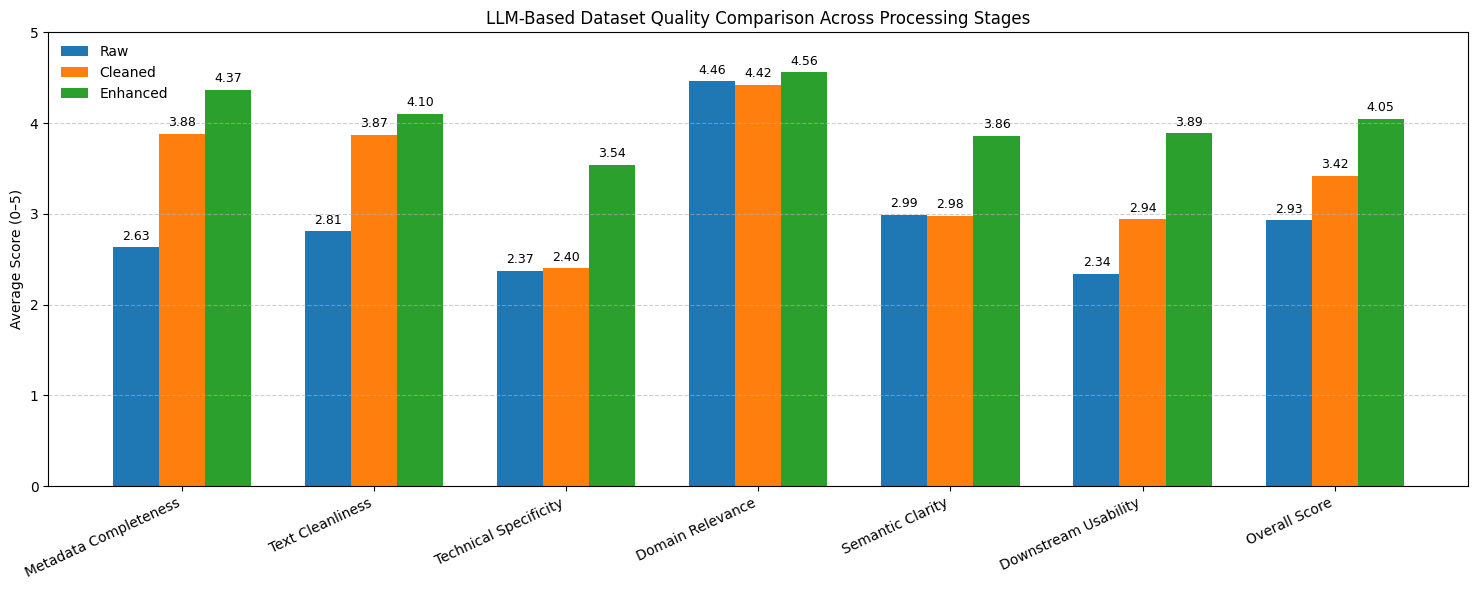

In [ ]:
# llm_score_plot.py
import json
import matplotlib.pyplot as plt
import numpy as np

def load_scores(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

# ===== Load data =====
raw_data = load_scores("llm_scores_raw.json")
cleaned_data = load_scores("llm_scores_cleaned.json")
enhanced_data = load_scores("llm_scores_full_enhanced.json")

datasets = [raw_data, cleaned_data, enhanced_data]
labels = ["Raw", "Cleaned", "Enhanced"]

score_keys = list(raw_data["scores"].keys())
metrics = [k.replace("_", " ").title() for k in score_keys]

raw_scores = [raw_data["scores"][k] for k in score_keys]
cleaned_scores = [cleaned_data["scores"][k] for k in score_keys]
enhanced_scores = [enhanced_data["scores"][k] for k in score_keys]

x = np.arange(len(metrics))
width = 0.24

# ===== Plot =====
plt.figure(figsize=(15, 6))

bars_raw = plt.bar(x - width, raw_scores, width, label="Raw")
bars_cleaned = plt.bar(x, cleaned_scores, width, label="Cleaned")
bars_enhanced = plt.bar(x + width, enhanced_scores, width, label="Enhanced")

plt.xticks(x, metrics, rotation=25, ha="right")
plt.ylabel("Average Score (0–5)")
plt.ylim(0, 5.0)
plt.title("LLM-Based Dataset Quality Comparison Across Processing Stages")

plt.legend(frameon=False)
plt.grid(axis="y", linestyle="--", linewidth=0.8, alpha=0.6)

# ===== Value annotations =====
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.05,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

annotate_bars(bars_raw)
annotate_bars(bars_cleaned)
annotate_bars(bars_enhanced)

plt.tight_layout()
plt.show()
